# 第四章 图像分割

## 4.1 什么是图像分割？

　　图像分割就是给定一张图片，预测图像中每个像素的类别。它有三个子问题：一是只输出目标类别，称为语义分割（如图１(c)）；二是区分不同目标的实例，称为实例分割（如图１(d)）；三是区分图像中所有的物体，包括天空，道路，建筑，沙滩，草地等场景，称为全景分割（如图２中的(d)）。
  
<center><img src="output/book01.jpg" />图１ 图像识别的核心任务</center><br>
<center><img src="output/book02.jpg" />图2 全景分割实例</center>

　　语义分割和实例分割要分割的目标，通常具有一定的边界，如人，车等常规目标，是可数的，全景分割中包含不可数目标，所以，从范围上说，全景分割包含语义分割和实例分割，但全景分割不允许同一像素归为不同的目标，它带来的好处是可以在图上进行像素级别的推理。显然，全景分割难度最高，应用价值最大，实例分割次之，语义分割最简单，现在主流分割算法主要解决实例分割，本章也集中精力研究实例分割算法Mask R-CNN。

## 4.2 常用数据集
　　主要介绍四个：Pascal VOC，CityScapes，MS COCO，ADE20K。
  
　　第一个是Pascal VOC数据集，这是一个老牌数据集，它提供20个类别，包括人，车等。2012版有9993张标注图，提供了类别标注和实例标注，既可以做语义分割，也可以做实例分割，把不同的人车标记出来。
  
<center><img src="output/book03.jpg" />图3 Pascal VOC分割例子</center>

　　第二个是CityScapes数据集，主要面向道路驾驶场景，有30个类，图片来自50城市，其中有5000张图进行了精细标注，精确到像素级别， 20000 张图片有粗糙的标注，可以做语义分割和实例分割。
  
<center><img src="output/book04.jpg" />图4 CityScapes精标图</center><br>
<center><img src="output/book05.jpg" />图5 CityScapes粗标图</center>

　　第三个是MS COCO数据集，这是目前语义分割的最大数据集，80类，超过30万张图片，其中20万张有标注，实例超过200万个，最新论文一般都会在MS COCO数据集上做实验，因为它难度最大，挑战性最高。图１就是来自于MS COCO的样本，本章后面结合Mask R-CNN有更详细的分析。
    
　　第四个是ADE20K数据集，训练集含20210张图片，验证集含2000张图片，每张图像，目标和部件分割被存储为不同的png文件，分割从上到下，包含天空、墙、建筑和地板等场景。
<center><img src="output/book06.jpg" />图6 ADE20K标注实例</center>

## 4.3 传统分割算法

　　传统图像分割最具代表性的就是图切割算法GraphCut和GrabCut，它们都需要提供前景和背景像素种子，通过种子建立前景背景概率分布模型来估算所有像素属于前景和背景的概率。直观上，种子越多越精确，分割精度就越高，当种子无法覆盖所有分布时，会影响分割的准确度。

### 4.3.1 GraphCut
　　将图像中的每个像素看成图中的一个节点，首先在图中增加两个节点，分别为F和B，F代表前景，而B代表背景，其次每两个相邻像素点用一条边连起来，每个像素点和F点用一条边连起来，每个像素点和B点也用一条边连起来，形成一个带权重的无向图，如下图：
  
<center><img src="output/book07.jpg" />图7 GraphCut无向图</center>
 
　　一个切割就是将图像分成两部分，第一部分的像素点和F相连为前景，第二部分的像素点和B相连为背景，切割通过优化以下能量函数来实现：

<center><img src="output/book08.jpg" />图8 GraphCut能量函数</center>
  
　　其中g(X)为数据(Data)项，由像素v属于前景和属于背景的概率决定，h(v,u)称为平滑(Smoothness)项，由像素v和其邻接像素u的相似程度决定。最简单的前景背景概率计算就是基于图像的直方图，而衡量两个相邻像素点相似度最简单的方法则是用灰度差值。通过上式可以看到，能量的最优化就是将最有可能是前景的列为一组，最有可能是背景的列为另一组，然后将灰度差最大的相邻像素切割开来，这样的分割是全局最优分割。

### 4.3.2 GrabCut

　　GrabCut可看成GraphCut的升级版，主要改进是：一是简化种子的选取方法，用户只要用一个矩形框住前景；二是迭代优化前景和背景分布的概率模型ＧＭＭ－－高斯混合模型。具体步骤如下：
   
　　1. 用矩形外的像素作为背景，矩形内的像素作为前景，分别训练背景和前景GMM；
  
　　2. 用训练好的GMM来计算每个像素属于背景和前景的概率，即计算出能量函数E中的Data项，计算Smoothness项的方法与GraphCut大致相同；
  
　　3. 用最优化能量函数完成图的最小分割，从而完成图像分割；
  
　　4. 用3中的分割结果（前景和背景像素）再次训练前景和背景GMM；
  
　　5. 重复步骤2，3，4，直到分割结果收敛。
  
　　从上述步骤可以看出，GrabCut是一个迭代算法，目标是分割能量最小，期望最大化（EM--Expectation Maximization）。它假定用户提供的矩形内部是前景，外部是背景，遗憾地是，内部也可能有背景像素，所以种子是不完全正确的，更严重的是存在仅凭颜色无法区分背景和前景的系统性难题。好在GMM模型并不要求所有初始数据都正确，即使有部分不正确，也可以通过EM步骤得到适当纠正，GrabCut正是利用了GMM的这一特性才表现良好。值得注意的是，GMM有可能陷入局部最优，所以GrabCut也有此问题。


#### 实战

　　OpenCV实现了GrabCut算法，下面代码是一个简易包装，可完成抠图，程序首先对图片缩放，然后选取种子矩形(距图片边界10个像素)，最后迭代16次输出。

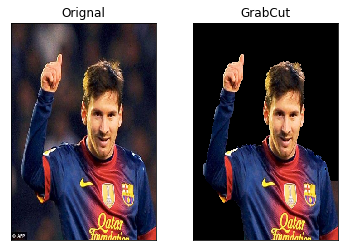

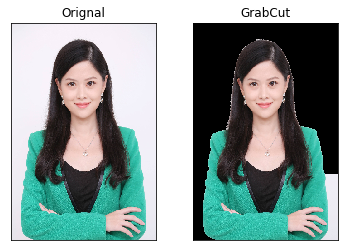

CPU times: user 7.75 s, sys: 222 ms, total: 7.97 s
Wall time: 12.3 s


In [1]:
%%time
# tools/grabcut.py
import sys
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

RESIZE_WIDTH = 320
RESIZE_HEIGHT = 480


def resize_grabcut(img):
    """Image Resize and Grab Cut."""
    img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))

    mask = np.zeros((img.shape[:2]), np.uint8)
    bgmodel = np.zeros((1, 65), np.float64)
    fgmodel = np.zeros((1, 65), np.float64)

    border = 10
    rect = (border, border, img.shape[1] - border, img.shape[0] - border)

    cv2.grabCut(img, mask, rect, bgmodel, fgmodel, 16, cv2.GC_INIT_WITH_RECT)

    # 0 -- cv2.GC_BGD, 1 -- cv2.GC_FGD, 2 -- cv2.GC_PR_BGD, 3 -- cv2.GC_PR_FGD
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    return img * mask2[:, :, np.newaxis]


def images_show(image1, image2, title1=None, title2=None):
    """Show images."""
    plt.subplot(1, 2, 1)
    plt.title('image 1' if not title1 else title1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.title('image 2' if not title2 else title2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

    plt.show()


def grabcut(image_filename):
    """Two stages image grab cut."""
    image = cv2.imread(image_filename)
    image = cv2.resize(image, (RESIZE_WIDTH, RESIZE_HEIGHT))

    result = resize_grabcut(image)

    images_show(image, result, 'Orignal', 'GrabCut')


grabcut("images/messi.jpg")
grabcut("images/girl.jpg")

#### 改进方向
　　可以看到，GrabCut运行慢，抠图效果一般。效果方面，有两个改进方向：一是毛边严重，可采用导向滤波等算法改进；二是抠图错误，可采用深度学习方法改进，这里有一个连接供您参考：
https://github.com/jfzhang95/DeepGrabCut-PyTorch.git
。

## 4.4 Mask R-CNN

　　传统图像分割算法只利用了图像本身的颜色、纹理等底层信息，无法从高层语义信息中获取增强线索，所以正确的图像分割算法必然会借助深度学习的方法来逾越底层到高层的信息鸿沟，Mask R-CNN就是一个极其优秀的例子，它由何凯明博士团队发明，荣获ICCV2017最佳论文奖（Marr Prize），论文地址：https://arxiv.org/abs/1703.06870 。

### 4.4.1 概述
> #### 摘要
>
>　　我们提出了一个概念上简单，灵活和通用的目标分割框架。我们的方法能有效地检测图像中的目标，同时为每个实例生成高质量的分割掩码。称为Mask R-CNN的方法通过添加一个与现有目标检测框回归并行的，用于预测目标掩码的分支来扩展Faster R-CNN。Mask R-CNN训练简单，相对于Faster R-CNN，只需增加一个较小的开销，运行速度可达5 FPS。此外，Mask R-CNN很容易推广到其他任务，例如，允许我们在同一个框架中估计人的姿势。我们在COCO挑战的所有三个项目中取得了最佳成绩，包括目标分割，目标检测和人体关键点检测。在没有使用额外技巧的情况下，Mask R-CNN优于所有现有的单一模型，包括COCO 2016挑战优胜者。我们希望我们的简单而有效的方法将成为一个促进未来目标级识别领域研究的坚实基础。我们稍后将提供代码。

>    来自论文《Mask R-CNN》的中文翻译

　　**Mask R-CNN是什么，可以做哪些任务？**

　　简单地说，Mask R-CNN就是一个通用的实例分割架构，可以用来做“目标检测”、“实例分割”、“关键点检测”等任务。

　　下面是三个例子，很明显，它几乎可以直接应用到“自动驾驶”，"人体姿态检测"，“智慧医疗”等领域。

<center><img src="output/book09.jpg" />图9 分割实例</center><br>
<center><img src="output/book10.jpg" />图10 人体关键点检测</center><br>
<center><img src="output/book11.jpg" />图11 分割细胞核</center>

### 4.4.2 架构
  
　　**Mask R-CNN的架构长什么样？创新在哪里?**
   
　　论文《Mask R-CNN》明确告诉我们：Mask R-CNN就是Faster R-CNN的直接扩展，Faster R-CNN已有目标分类和目标检测模块，Mask R-CNN扩展的就是目标分割模块，整体模型如图12所示。这里，Mask是掩码的英文名，代表分割，CNN是Convolutional Neural Network的缩写，中文名叫卷积神经网，R是Region的缩写，表示在区域上工作。
  
<center><img src="output/book15.jpg" />图12 Mask R-CNN 模型总览</center>

  
  图13是论文给出的架构图。
 
　　<center><img src="output/book12.jpg" />图13 R-CNN 系统架构</center>
 
   它的创新之处在于：

　　第一，**三剑合一**：增加目标分割分支，将目标分类、检测、分割算法统一到一个框架下；
  
　　第二，**ROI精准对齐**：提出了一个简单的，量化无关的层，称为RoIAlign，可保留精确的空间位置；
  
　　第三，**掩码解耦**：Mask R-CNN为每个类独立地预测二进制掩码，消除了跨类竞争。 
  
　　所以，Mask R-CNN是在Faster R-CNN的基础上演化而来的，粗略地说，它就是Faster R-CNN和FCN的结合，前者负责目标检测（分类标签,确定位置），后者负责目标分割 (确定掩码）。其关系如图14：
  
<center><img src="output/book13.jpg" />图14 Mask R-CNN ＝ Faster R-CNN + FCN</center>

### 4.4.3 实现

　　Mask R-CNN在github上有多种开源版本，官方用Caffe2实现，地址位于https://github.com/facebookresearch/Detectron　，我们选取 https://github.com/delldu/MaskRCNN 来分析。选择的理由非常简单：该版本是用**PyTorch**实现的，通过了我们的**测试**。它的安装和使用方法，请参见项目自带的README.md。

#### 4.4.3.1 数据探索

　　训练和验证数据集是MS COCO 2014。

##### 文件概览
　　首先，数据集包含两类文件：１.标注文件，位于annotations目录下，json格式；２．图像文件，jpg格式，例子如下：

    data
    ├── annotations
    │   ├── captions_train2014.json
    │   ├── captions_val2014.json
    │   ├── instances_minival2014.json
    │   ├── instances_train2014.json
    │   ├── instances_val2014.json
    │   ├── instances_valminusminival2014.json
    │   ├── person_keypoints_train2014.json
    │   └── person_keypoints_val2014.json
    ├── test2014
    │   ├── COCO_test2014_000000000001.jpg
    │   ├── COCO_test2014_000000000014.jpg
    │   ├── COCO_test2014_000000000016.jpg
    │   ├── COCO_test2014_000000581919.jpg
    │   └── COCO_test2014_000000581923.jpg
    ├── train2014
    │   ├── COCO_train2014_000000000009.jpg
    │   ├── COCO_train2014_000000000049.jpg
    │   ├── COCO_train2014_000000000061.jpg
    │   ├── COCO_train2014_000000581909.jpg
    │   └── COCO_train2014_000000581921.jpg
    └── val2014
    ​    ├── COCO_val2014_000000000042.jpg
    ​    ├── COCO_val2014_000000000139.jpg
    ​    ├── COCO_val2014_000000000143.jpg
    ​    ├── COCO_val2014_000000581913.jpg
    ​    └── COCO_val2014_000000581929.jpg

　　其次，请重点关注标注文件，因为标注文件是json的紧凑格式，细项堆积在一起，难以阅读，可以使用json工具给予转换，命令如下：

`cat data/annotations/instances_valminusminival2014.json | python -m json.tool`

　　一个标注文件对应多个图像，它相当一个数据库，通过它可以检索到图像文件的ＩＤ，文件名称，图片包含的目标类别，位置框，掩码等信息。

##### 访问实战

　　和通常PyTorch模型使用数据的要求一样，先构造标准的Dataset类CocoMaskRCNNDataset，它从torchvision.datasets.CocoDetection继承而来，后者从torch.utils.data.Dataset继承而来，需要实现关键函数`__len__()，__getitem__(index)`，分别用于获取样本的总数和单样本的内容，实际内容包括图片数据，标注类别，目标框和掩码，它的复杂性在于：一、分析标注文件，获取基本的标注信息，这部分已由cocoapi实现，请参阅https://github.com/cocodataset/cocoapi.git
；二、同步转换图片大小，目标框大小和掩码，并规范化成张量，以适应后续深度网络处理的需要，我们实现了这一部分，核心内容存储在文件data.py中，大家可以尽情探索。

　　**重要提示**
  
　　PyTorch模块nn.Module中的输入一般是BxCxHxW形式的张量(B代表批量，C代表通道，H代表高度，W代表宽度)，所以我们要将CocoMaskRCNNDataset中的图片处理成CxHxW维张量，经过torch.utils.data.DataLoader调用后才能形成BxCxHxW维张量，进入网络运算。实际上初始输入图像的维度是3x1024x1024。

In [1]:
import data
import config

valid_dataset = data.CocoMaskRCNNDataset("data", "valminusminival", 2014, config.Config())
valid_dataset.summary()


loading annotations into memory...
Done (t=5.00s)
creating index...
index created!
Dataset pictures: 35504
Dataset memory 712628120 bytes, about 679 M.


##### 改进方向

　　可以看出，instances_valminusminival2014.json标注了35504张图片，**值得注意**的是：数据占用内存达到**679Ｍ**！这里可以改进的是：将标注文件和图片转换一次完成，并存入数据库中，学习网络直接从数据库中获取数据，既能减小内存占用，又能加快训练速度。

##### 原始标注

In [2]:
valid_dataset.show(4000)

Image file ID:  449856 , name:  data/val2014/COCO_val2014_000000449856.jpg
Image size: Height x Width =  631 x 640


<center><img src="output/bear.jpg" />图15 原始标注样本</center>

##### 规范输入

　　网络输入的图片需要统一变换到3x1024x1024维张量，然后减去ImageNet图像集的颜色均值(RGB[123.7, 116.8, 103.9])。维度变换就是图像缩放：保持图像实质内容长宽比率不变，短边缩放到800像素，长边不超过1024像素，边框不足部分用黑色填充，如下图所示。

In [3]:
valid_dataset.net_show(4000)

Image file ID:  449856 , name:  data/val2014/COCO_val2014_000000449856.jpg
Image size: Height x Width =  1024 x 1024


<center><img src="output/net_bear.jpg" />图16 缩放图片样本</center>

##### 类别空洞
　　需要注意的是，COCO数据集的原始类别并不是连续的，例如标识为"traffic light"的类别号为84，它超出了数据集类别(含背景共81类)的上限，原因是标注文件类别有些类别(如类别12)不存在，类别空间存在“空洞”，而深度学习网络中的标签一般要求连续，所以需要转换。为此，我们开发了CocoLabel类辅助转换，同时可以获取类别中文名称，具体请参阅data.py中的CocoLabel类。

In [4]:
import data

print(data.CocoLabel.name(10))
print(data.CocoLabel.zh_name(10))
print(data.CocoLabel.from_class(84))
print(data.CocoLabel.to_class(74))

traffic light
红绿灯
74
84


#### 4.4.3.2 模型分解
　　Mask R-CNN包含５个子网：卷积骨干网，特征金字塔网，区域建议网，分类检测网和目标分割网，其中卷积骨干网和特征金字塔网主要用于提取网络特征，区域建议网给出可能包含目标的图像区域，分类检测网完成目标分类和位置检测，目标分割网完成目标分割掩码的计算，５个子网协同工作，共同构成一个深度学习监督网络。下面根据模型总揽图来逐一分解，先介绍相关背景知识，然后说明具体实现。**重要的事要说三遍**，**重要的图也要贴两遍**，所以再贴一遍模型总览图！
<center><img src="output/book15.jpg" />图17 Mask R-CNN 模型总览</center>

##### 背景知识

###### 监督学习模型

　　监督学习可以概括成如下模型：

　　目标: 学出模型 $Y=f(X)$
  
　　训练: 通过样本 (X, Y) 训练出$f$。
  
　　推理: 给定X, 通过$f$计算出Y。

　　约束: 
  
　　　　1)维度约束: X, Y 的特征维度固定；
    
　　　　2)目标约束: 训练时，f(X)与Y尽可能相近，推理时，f(X)尽可能与实际相近。
    
　　尽管Mask R-CNN网络结构复杂，但最核心的就是这个模型，所以我们后面会按照这个思路来详细剖析。

###### 检测框

　　检测框，简称框(Box)，是一个矩形，在Mask R-CNN实现中用[y1, x1, y2, x2]表示，左上角坐标为[y1, x1], 右下角为[y2, x2], y从上到下，x从左到右。Mask R-CNN中有各种各样的框，一个锚点是一个框，一个感兴趣区域也是一个框。
  
###### 绑定框

　　绑定框(Bounding Box)对应的是框(Box)的偏移，**和谁绑定？**在建议网中和锚点绑定，在检测网中和ROI(感兴趣区域，由建议网生成)绑定。它的缺省值是[0, 0, 0, 0]，实现中变量名常包含关键字bbox或delta。建议网和检测网输出的检测框采用绑定框，既简化了网络设计，又降低了训练难度，增加了稳定性。设想一下：即使没有任何训练，偏移基本正确(在０附近)！Faster R-CNN把偏移的高度和宽度取对数，还原正常值时取指数，好处是把较大的偏移转换成近似线性变化，对较小偏移几乎没有影响，设计很巧妙！

###### ROI

　　ROI是感兴趣区域的英文缩写，也一个框，在Mask R-CNN中表示为相对值，4个分量是浮点数，取值位于[0,1]中，通过它截取局部特征，无论大的特征图在空间上如何变化(变大或变小) ，框内的内容实质上都指向同一内容，这是它的美妙之处。
  
###### 覆盖矩阵
　　两个框box1和box2之间可能有重叠，重叠程度常用IoU来度量，即用box1与box2交集的面积除以二者并集的面积。如果有两个框集合，比如A和G，A中的框A<sub>i</sub>与G中的框G<sub>j</sub>的IoU记为s<sub>ij</sub>,则全部s<sub>ij</sub>构成一个矩阵，我们称为覆盖矩阵。例如:

|  | G<sub>1</sub>   | G<sub>2</sub> | ... |
| ------ | ------ | ------ |
| A<sub>1</sub>   | 0.1 | 0.2 |
| A<sub>2</sub>   | 0.9 | 0.3 |
| A<sub>3</sub>   | 0.2 | 0.3 |
|... | | |

###### 全卷积网
　　全卷积网的英文缩写是FCN，全称是Fully Convolutional Network。
  
　　通常CNN网络在卷积层之后会接上若干个全连接层，将卷积层产生的特征图映射成一个固定长度的特征向量。以AlexNet为代表的经典结构适合于图像的分类和回归任务，因为它们最后都期望得到整个输入图像的一个数值描述（概率），比如AlexNet的ImageNet模型输出1000维的向量表示输入图像属于每一类的概率。图18中的猫，输入AlexNet，得到一个长为1000的输出向量， 表示输入图像属于每一类的概率，其中在“tabby cat”这一类概率最高。
  <center><img src="output/book23.jpg" />图18 CNN分类示意图</center>
  
　　FCN是把所有的全连接层换成卷积层，原来只能输出一个类别的网络就可以在特征图的每一个像素处输出一个分类结果，这样把原来分类的向量，变成了分类的特征图（热图），原理示意如下：
  <center><img src="output/book24.jpg" />图19 CNN到FCN的改进</center>
  
　　因此，FCN可以接受任意尺寸的输入图像，采用反卷积层对最后卷积层的特征上采样，使它恢复到与输入图像相同的尺寸，可以对每个像素产生预测值，因为它保留了原始输入图像中的空间信息，所以最后可以在上采样的特征图上进行逐像素分类，从而解决了图像语义分割的问题(只能区分类别，无法区分实例)。图20是FCN的作者给出的用于语义分割的全卷积网络的结构图：
  <center><img src="output/book25.jpg" />图20 FCN分割结构图</center>

　　为了空间映射，需要放大特征图，把特征图恢复到原图的大小，常用的方法有三种：一是反卷积（Deconvolution），这里反卷积不是真正意义的“卷积逆”，用“转置卷积”（Transposed Convolution）代替更合适，但原论文中用的是Deconvolution，本章还是沿用这个名词，它的主要目的是实现上采样；二是膨胀卷积（Dilated Convolution），或者更形象地称为带洞卷积，它可以使特征图视野变大，但不增加计算量，对图像分割，有利于提取全局信息，使得分割更准确（如图21）；三是双线性插值上采样，它是一个古老的技术，计算公式如图22，在Mask R-CNN的ROI对齐上使用了这一技术，能显著地提高分割的精度，是Mask R-CNN的核心模块。
  <center><img src="output/book26.jpg" />图21 膨胀卷积示意图</center>
  <center><img src="output/bilinear.png" />图22 双线性插值</center>


##### 卷积骨干网

　　项目中Mask R-CNN的卷积骨干网使用的是残差网络Resnet101，网络在前向传播中，特征图会逐步变小。根据特征图的大小，可分为５个阶段，每个阶段特征图大小不变。如果把第i个阶段的最后残差激活输出记为$C_i$，最终有５个输出${C_1，C_2，C_3，C_4，C_5}$，相对于输入图像3x1024x1024，像素步长分别为{2，4，8，16，32}。

###### 网络定义

In [ ]:
############################################################
#  Resnet Graph
############################################################
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(planes, eps=0.001, momentum=0.01)
        self.padding2 = SamePad2d(kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(planes, eps=0.001, momentum=0.01)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(planes * 4, eps=0.001, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.padding2(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, architecture, stage5=False):
        super(ResNet, self).__init__()
        assert architecture in ["resnet50", "resnet101"]
        self.inplanes = 64
        self.layers = [3, 4, {"resnet50": 6, "resnet101": 23}[architecture], 3]
        self.block = Bottleneck
        self.stage5 = stage5

        self.C1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64, eps=0.001, momentum=0.01),
            nn.ReLU(inplace=True),
            SamePad2d(kernel_size=3, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.C2 = self.make_layer(self.block, 64, self.layers[0])
        self.C3 = self.make_layer(self.block, 128, self.layers[1], stride=2)
        self.C4 = self.make_layer(self.block, 256, self.layers[2], stride=2)
        if self.stage5:
            self.C5 = self.make_layer(
                self.block, 512, self.layers[3], stride=2)
        else:
            self.C5 = None

    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)
        x = self.C3(x)
        x = self.C4(x)
        if self.C5:
            x = self.C5(x)
        return x

    def stages(self):
        return [self.C1, self.C2, self.C3, self.C4, self.C5]

    def make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride),
                nn.BatchNorm2d(
                    planes * block.expansion, eps=0.001, momentum=0.01),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

###### 特征扩边
  
　　您可能也和我当初一样好奇，如何才能做到每个阶段的特征图大小一样？答案很简单，就是在卷积、池化前，先对特征扩边，如下图所示：
  
  <center><img src="output/samepad.jpg"　/>图23 特征扩边</center>
  
　　实做中“特征扩边”是用如下代码定义的(model.py)：


In [ ]:
class SamePad2d(nn.Module):
    """'SAME' padding."""

    def __init__(self, kernel_size, stride):
        """Init."""
        super(SamePad2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, input):
        """Keep feature size not changing after CNN."""
        in_width = input.size(2)
        in_height = input.size(3)
        out_width = math.ceil(float(in_width) / float(self.stride))
        out_height = math.ceil(float(in_height) / float(self.stride))
        pad_along_width = (
            (out_width - 1) * self.stride + self.kernel_size - in_width)
        pad_along_height = (
            (out_height - 1) * self.stride + self.kernel_size - in_height)
        pad_left = math.floor(pad_along_width / 2)
        pad_top = math.floor(pad_along_height / 2)
        pad_right = pad_along_width - pad_left
        pad_bottom = pad_along_height - pad_top
        return F.pad(input, (pad_left, pad_right, pad_top, pad_bottom), 'constant', 0)

    def __repr__(self):
        """Dump class name."""
        return self.__class__.__name__

##### 特征金字塔网

###### 背景介绍
　　特征金字塔网络的英文全称是Feature Pyramid Network，缩写为FPN。
  
　　多尺度目标检测是机器视觉领域的开放课题，极具挑战。直观上看，在图像金字塔上提取特征来构建特征金字塔，可以检测大范围内尺度变化的目标，具有一定的尺度不变性，但是它有很大的局限性: 首先运算时间成倍增加，其次实践证明在训练深度网络时太吃显存，难以使用。因此FPN另辟蹊径，通过融合卷积网输出的多层特征图来构建金字塔 ，在金字塔的每层特征图上来检测目标，推断类别。

<center><img src="output/book16.jpg" />图24 FPN结构图</center>

　　我们把上图左边的三个特征图称为$C_1、C_2、C_3$，它来自卷积骨干网，右边的三个特征图称为$P_1、P_2、P_3$，是FPN的输出。实际上，这是FPN结构的一个简化图，实做稍复杂，有５层，如图25。它有自下而上、自上而下、横向连接三条路径：

<center><img src="output/book17.jpg" />图25 实做FPN结构图</center>

　　1.自下而上：就是卷积网的前馈输出，该算法计算出不同比例的特征图，缩放比例为2，具体是Resnet101中的{$C_2，C_3，C_4，C_5$}，因为内存占用较大，实做中没有把$C_1$映射到$P_1$。
  
　　2.自上而下：首先将空间低分辨率的特征图2倍上采样，其次与空间高分辨率的特征图（横向连接后的结果）逐元素相加合并，最后，在合并图上附加一个3×3卷积来生成最终的特征映射，目的是减少上采样的混叠效应，最终的特征映射集称为{$P_2，P_3，P_4，P_5$}，分别对应于{$C_2，C_3，C_4，C_5$}，$C_i$与$P_i$之间具有相同的维度；为了目标前景检测，$P_5$还下采样到$P_6$。
  
　　3.横向连接：主要实施1x1或3x3卷积，目的是将$C_i$的输出转换成与$P_i$相同的维度。
  
　　由于金字塔的所有层共享分类器和回归器，因此所有特征图中选取相同的输出通道(实做选取256）。两组特征{$P_2，P_3，P_4，P_5，P_6$}，{$P_2，P_3，P_4，P_5$}分别作为区域建议网、目标检测网和目标分割网的输入特征来源，完成目标检测和分割任务。

###### 特征维度

|  | C  | H | W |
| ------ | ------ | ------ | ------ |
| P<sub>2</sub>   | 256 | 256 |256|
| P<sub>3</sub>   | 256 | 128 |128|
| P<sub>4</sub>   | 256 | 64 |64|
| P<sub>5</sub>   | 256 | 32 |32|
| P<sub>6</sub>   | 256 | 16 |16|

　　这里的描述看起来抽象复杂，但FPN的定义本身可以用如下代码(model.py)简洁地完成。

###### 网络定义

In [ ]:
class FPN(nn.Module):

"""See the paper "Feature Pyramid Networks for Object Detection" for more details."""

def __init__(self, C1, C2, C3, C4, C5, out_channels):
    """FPN Init."""
    super(FPN, self).__init__()
    self.out_channels = out_channels
    self.C1 = C1
    self.C2 = C2
    self.C3 = C3
    self.C4 = C4
    self.C5 = C5
    self.P6 = nn.MaxPool2d(kernel_size=1, stride=2)
    self.P5_conv1 = nn.Conv2d(2048, self.out_channels, kernel_size=1, stride=1)
    self.P5_conv2 = nn.Sequential(
        SamePad2d(kernel_size=3, stride=1),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
    )
    self.P4_conv1 = nn.Conv2d(
        1024, self.out_channels, kernel_size=1, stride=1)
    self.P4_conv2 = nn.Sequential(
        SamePad2d(kernel_size=3, stride=1),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
    )
    self.P3_conv1 = nn.Conv2d(
        512, self.out_channels, kernel_size=1, stride=1)
    self.P3_conv2 = nn.Sequential(
        SamePad2d(kernel_size=3, stride=1),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
    )
    self.P2_conv1 = nn.Conv2d(256, self.out_channels, kernel_size=1, stride=1)
    self.P2_conv2 = nn.Sequential(
        SamePad2d(kernel_size=3, stride=1),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1),
    )

def forward(self, x):
    x = self.C1(x)
    x = self.C2(x)
    c2_out = x
    x = self.C3(x)
    c3_out = x

    x = self.C4(x)
    c4_out = x
    x = self.C5(x)
    p5_out = self.P5_conv1(x)

    p4_out = self.P4_conv1(c4_out) + F.interpolate(p5_out, scale_factor=2)
    p3_out = self.P3_conv1(c3_out) + F.interpolate(p4_out, scale_factor=2)
    p2_out = self.P2_conv1(c2_out) + F.interpolate(p3_out, scale_factor=2)

    p5_out = self.P5_conv2(p5_out)
    p4_out = self.P4_conv2(p4_out)
    p3_out = self.P3_conv2(p3_out)
    p2_out = self.P2_conv2(p2_out)

    p6_out = self.P6(p5_out)

    return [p2_out, p3_out, p4_out, p5_out, p6_out]

###### 网络输出

In [5]:
from PIL import Image
import config as configlib
import model as modellib
import data as datalib
import tools.canvas as convaslib


def load_model():
    """Loading Mask R-CNN for coco."""
    config = configlib.CocoConfig()
    net = modellib.MaskRCNN(config=config, model_dir="logs")
    net.load_weights("models/mask_rcnn_coco.pth")
    net.eval()

    net.training = False
    net = net.cuda()

    return net

config = configlib.Config()
model = load_model()
image_file = "images/car58a54312d.jpg"


def show_fpn():
    """Ouput fpn network."""
    print(model.fpn)

show_fpn()

FPN(
  (C1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): SamePad2d
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (C2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (padding2): SamePad2d
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn2): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (

###### 可视化P2
　　FPN接受规范化的图片张量，调用Resnet101计算$C_1,C_2,C_3,C_4,C_5$,输出$P_2,P_3,P_4,P_5,P_6$。$P_2$是1x256x256x256(BxCxHxW格式)维张量，我们选取$P_2$的前16个二维张量(256x256)，将它可视化，输出到图26。可以看出，P2每个通道都保留了输入图的基本信息，从信息论的角度看，冗余较大，似乎可以简化，这应当是简化网络结构的有用线索。  

In [6]:
def show_image():
    """Show network input image."""
    image = Image.open(image_file)
    image, scale, cropbox = datalib.encode_image(image, 800, 1024)
    image.show()

show_image()


<center><img src="output/net_car.jpg" />图26 测试网络图</center>

In [ ]:
def show_p2():
    """Show P2."""
    image = Image.open(image_file)
    image, scale, cropbox = datalib.encode_image(image, 800, 1024)
    normalized_image = datalib.normalize_image(image, config.MEAN_PIXEL)
    normalized_image.unsqueeze_(0)
    normalized_image = normalized_image.cuda()
    [p2, p3, p4, p5, p6] = model.fpn(normalized_image)
    some_of_p2 = p2[:, :16, :, :]
    convaslib.tensor_show(some_of_p2)

show_p2()

<center><img src="output/net_p2.jpg" />图27 P2可视图</center>

##### 区域建议网

###### 背景介绍

　　区域建议网的英文全称是Region Proposal Network，简称RPN，来自论文《Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks》，网络结构如图27：
  
  <center><img src="output/book18.jpg" />图28 RPN结构图</center>
 
　　对于目标检测任务，快速生成可能的检测框是核心任务，经典检测方法都非常耗时，如滑动窗口结合图像金字塔的方法，或选择搜索(Selective Search)方法，Faster R-CNN则直接用RPN生成检测框，极大地提升了检测框的生成速度。

　　RPN网络的作用是输入特征图，输出一批候选矩形，每个矩形有两个分数，分别是前景（包含目标）和背景（不含目标）的概率。为了完成这个任务，我们按照1024x1024的尺寸，在空间上设置密密麻麻的候选框，每个框有固定的大小和位置，形象地称为锚点，如果有K个框(锚点)，就有２K个分数，４Ｋ个坐标位置。
  
  　<center><img src="output/book19.jpg" />图29 锚点分布示意图</center>

　　具体实现中，锚点有三种长宽比，分别为(sqrt(2)/2, 1.0, sqrt(2))，对应长形锚，方形锚，扁形锚，三种锚的中心点重合，其中方形锚的大小分别为{32, 64, 128,256, 512}共５种，这里sqrt(x)表示平方根函数，如图30所示，三种大小，三种形状，共９个锚点。之所以选择不同形状的锚点，是为了更好地与目标匹配，这与经典目标检测中选用各种各样的Haar算子有异曲同工之妙。当然选择的形状越多，匹配效果就越好，考虑到算力限制，实做中做了取舍。
<center><img src="output/book20.jpg" />图30 锚点形状示意图</center>

###### NMS算法
   
　　由于锚点相互重叠，因此候选框最终可能也会在同一目标上重复。为此，我们使用了非极大抑制(NMS)算法来去重，步骤如下：
  <center><img src="output/book21.jpg" />图31 NMS原始框图</center>

１．将所有候选框的得分进行排序，选中最高分及其所对应的框（标为红色）；
  <center><img src="output/book22.jpg" />图32 NMS选择过程示意图</center>

２．遍历其余的框，如果它和当前最高得分框的重叠面积大于一定的阈值，我们将其删除。

３．从没有处理的框中继续选择一个得分最高的，重复上述过程，得到最终结果。
  <center><img src="output/nms.png" />图33 NMS结果</center>


###### 网络模型

　　形式上，我们把区域建议网描述成：

　　$class\_logits, class, bbox = RPN([P_2, P_3, P_4, P_5, P_6])$
  
　　这里:
  
  　　　class是分类概率，共两个类别：背景和前景；

  　　　$class\_logits$是分类的回归值，在模型训练时用于评估损失，所以class等于$softmax(class\_logits)$。

　　把它的最小核心描述成：　$Y = rpn(X)$
  
　　**我们的任务就是要回答数据X，目标Ｙ和函数rpn是什么？**
   
　　答案是：X是锚点特征向量(512维)，Ｙ是锚点标签(2值)和锚点绑定框，rpn就是两个卷积函数(用全卷积代替全连接，作用类似线性回归)，这些满足了监督学习模型的约束条件，它是一个全卷积网。
  
　　我们以类别判断为例，画出获取X，Y的流程：

　　**$rpn$ 获取数据X的流程**

```flow
flow
s=>start: 开始 
image=>inputoutput: 图片 
fpn=>operation: FPN前向计算
p2p6=>inputoutput: P2-P6特征
conv=>operation: 3x3卷积
x=>inputoutput: X：锚点特征向量(512维)
e=>end: 结束

s->image(right)->fpn(right)->p2p6(right)->conv(right)->x->e
```

　　**$rpn$ 获取目标Y的流程**

```flow
flow
s=>start: 开始 
gtboxes=>inputoutput: 标注真值框 
overlaps=>operation: 锚点覆盖计算
sample=>operation: 平衡抽样(正负样本)
y=>inputoutput: Y：锚点标签(2值，共３对)
e=>end: 结束

s->gtboxes(right)->overlaps(right)->sample(right)->y->e
```

　　RPN的核心围绕锚点展开，体现在三个方面：
    
　　一、特征$P_2,P_3,P_4,P_5,P_6$的空间维度与锚点对应，特征提取以锚点为支撑，即同一空间位置有3个锚点，对应一个512维特征向量和3对标签数据，所以RPN网络定义中对分类最后卷积层的输出通道是6，对绑定框回归输出通道是12，**特别注意：**分类和绑定框回归，共享了同一特征向量。请参考以下锚点的分布统计表和后面的RPN网络定义：

|  | 锚类型 | H | W |小计|
| ------ | ------ | ------ | ------ | ------ |
| P<sub>2</sub>   | 3 | 256 |256|196608|
| P<sub>3</sub>   | 3 | 128 |128|49152|
| P<sub>4</sub>   | 3 | 64 |64|12288|
| P<sub>5</sub>   | 3 | 32 |32|3072|
| P<sub>6</sub>   | 3 | 16 |16|768|
| 总计 |  |  ||261888|

　　二、模型训练时，根据锚点与标注框之间的覆盖率(覆盖矩阵)，抽取正负样本；
    
　　三、模型推理时，給锚点打分，选取高分锚点及其检测框(ROI格式)推荐输出。

###### 网络定义

In [ ]:
class RPN(nn.Module):
    """Builds the model of Region Proposal Network."""

    def __init__(self, anchors_per_location, anchor_stride, depth):
        super(RPN, self).__init__()
        # anchors_per_location = 3
        self.anchor_stride = anchor_stride  # 1
        self.depth = depth  # 256

        self.padding = SamePad2d(kernel_size=3, stride=self.anchor_stride)
        self.conv_shared = nn.Conv2d(self.depth, 512, kernel_size=3, stride=self.anchor_stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv_class = nn.Conv2d(512, 2 * anchors_per_location, kernel_size=1, stride=1)
        self.softmax = nn.Softmax(dim=2)
        self.conv_bbox = nn.Conv2d(512, 4 * anchors_per_location, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.relu(self.conv_shared(self.padding(x)))

        # Anchor Score. [batch, anchors per location * 2, height, width].
        rpn_class_logits = self.conv_class(x)

        # Reshape to [batch, 2, anchors]
        rpn_class_logits = rpn_class_logits.permute(0, 2, 3, 1)
        rpn_class_logits = rpn_class_logits.contiguous()
        rpn_class_logits = rpn_class_logits.view(x.size()[0], -1, 2)

        # Softmax on last dimension of BG/FG.
        rpn_class = self.softmax(rpn_class_logits)

        # Bounding box refinement. [batch, H, W, anchors per location, depth]
        # where depth is [x, y, log(w), log(h)]
        rpn_bbox = self.conv_bbox(x)

        # Reshape to [batch, 4, anchors]
        rpn_bbox = rpn_bbox.permute(0, 2, 3, 1)
        rpn_bbox = rpn_bbox.contiguous()
        rpn_bbox = rpn_bbox.view(x.size()[0], -1, 4)

        return [rpn_class_logits, rpn_class, rpn_bbox]


###### 网络输出

In [8]:
print(model.rpn)

RPN(
  (padding): SamePad2d
  (conv_shared): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace)
  (conv_class): Conv2d(512, 6, kernel_size=(1, 1), stride=(1, 1))
  (softmax): Softmax()
  (conv_bbox): Conv2d(512, 12, kernel_size=(1, 1), stride=(1, 1))
)


###### 再论锚点

　　锚点到底长什么样？

　　我们知道，在$P_2,P_3,P_4,P_5,P_6$特征上都要建立锚点，如果网络输入图片大小为1024x1024, 总计有261888个锚点。下面以$P_3$为例，将锚点的中心点在网络图上标出。

In [9]:
def draw_anchors():
    """Draw anchors base on P3 dimension."""
    import data
    import utils
    image = Image.open("images/car58a54312d.jpg")
    image, scale, crop = data.encode_image(image, 800, 1024)
    anchors = utils.create_anchors(scales=64, ratios=[0.5, 1, 2], shape=[128, 128], feature_stride=8, anchor_stride=1)
    data.draw_anchors(image, anchors)

draw_anchors()

<center><img src="output/anchors.jpg" />图34 P3锚点分布图</center>

###### RPN NMS

　　如果不做筛选，RPN共有261888个锚点，所以有261888个建议框，根据RPN检测前景的得分结果，采用NMS抑制后，建议框大大减少，下面是测试代码和检测结果。这些建议框规范化后变成ROI，作为参数，会送入检测网络和分割网络。

In [10]:
def refine_rpn():
    """Refine rpn."""
    image = Image.open(image_file)
    image, scale, cropbox = datalib.encode_image(image, 800, 1024)

    normalized_image = datalib.normalize_image(image, config.MEAN_PIXEL)
    normalized_image.unsqueeze_(0)
    normalized_image = normalized_image.cuda()
    [p2, p3, p4, p5, p6] = model.fpn(normalized_image)

    rpn_class_logits, rpn_class, rpn_bbox = model.rpn_detect([p2, p3, p4, p5, p6])
    rpn_rois = model.rpn_refine(rpn_class, rpn_bbox)
    rpn_rois.squeeze_(0)

    boxes = datalib.boxes_scale(rpn_rois, [1024, 1024, 1024, 1024])
    datalib.blend_image(image, None, boxes, masks=None, scores=None).show()

refine_rpn()

<center><img src="output/rpn_first.jpg" />图35 RPN建议框</center>

##### 目标检测网

###### ROI 对齐
　　检测网和分割网都接受ＦＰＮ输出的特征和RPN输出的ＲＯＩ，对检测网，需要在[P<sub>2</sub>, P<sub>3</sub>, P<sub>4</sub>, P<sub>5</sub>]上提取每个ＲＯＩ对应的特征，并把它统一成256x7x7的特征张量，然后经过２次卷积，拉伸成1024维向量，作为$detect$的Ｘ变量；对分割网，挖补的特征要统一成256x14x14的特征张量，再经过４次卷积和１次反卷积，变成256x28x28的特征张量，最后卷积１次，产生81x28x28维张量，作为$mask$的输入变量X，由此可以看出，检测网和分割网都共享了ＦＰＮ输出的基础特征，差别在于二者细化时，输出结果稍有差异。这里核心算法是利用双线性插值算法进行精确的特征挖补(ROI对齐)，不象Faster R-CNN粗略地只做２次量化，所以它显著地提高了检测和分割的精度，是论文《Mask R-CNN》的重要贡献。

###### 网络模型

　　形式上，我们把目标检测网描述成：
  
　　　　$class\_logits, class, bbox = Detect([P_2, P_3, P_4, P_5], rois)$
    
　　这里: 

　　　　rois 是RPN输出的ROI集合；

　　　　class是分类概率，共计81(包括背景)；

　　　　$class\_logits$是分类回归值，主要在训练时用于评估损失，即class等于$softmax(class\_logits)$;

　　　　bbox 是检测绑定框。

　　同时把它的最小核心描述成：　$Y = detect(X)$
  
　　**我们的任务就是要回答数据X，目标Ｙ和函数detect是什么？**
   
　　答案是：X是来自$[P_2,P_3,P_4,P_5]$上的256x7x7特征块，经过一系列卷积变换生成的1024维向量；Ｙ是标注类别(81类)和真值绑定框(通过标注框与ROI计算得到），detect是两个线性回归函数，这些同样满足了监督学习模型的约束条件，但它是一个**全连接网！**
  
　　以下给出获取X，Y的流程：

　　**$detect$ 获取数据X的流程**

```flow
flow
s=>start: 开始 
p2p5=>inputoutput: P2-P5特征，ROI
roialign=>operation: ROI对齐
x7x7=>inputoutput: 256x7x7特征图
conv=>operation: 卷积变换
x=>inputoutput: X：1024维向量
e=>end: 结束
s->p2p5(right)->roialign(right)->x7x7(right)->conv(right)->x->e
```

　　**$detect$ 获取目标Y的流程**

```flow
flow
s=>start: 开始 
y=>inputoutput: Y：标注类别(81类),真值绑定框
e=>end: 结束
s(right)->y(right)->e
```

###### 网络定义

In [ ]:
class Classifier(nn.Module):

    def __init__(self, depth, pool_size, image_shape, num_classes):
    
        super(Classifier, self).__init__()
        self.depth = depth
        self.pool_size = pool_size
        self.image_shape = image_shape
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.depth, 1024, kernel_size=self.pool_size, stride=1)
        self.bn1 = nn.BatchNorm2d(1024, eps=0.001, momentum=0.01)
        self.conv2 = nn.Conv2d(1024, 1024, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(1024, eps=0.001, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)

        self.linear_class = nn.Linear(1024, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.linear_bbox = nn.Linear(1024, num_classes * 4)

    def forward(self, x, rois):
        x = roi_align([rois] + x, self.pool_size, self.image_shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = x.view(-1, 1024)
        mrn_class_logits = self.linear_class(x)
        mrn_probs = self.softmax(mrn_class_logits)

        mrn_bbox = self.linear_bbox(x)
        mrn_bbox = mrn_bbox.view(mrn_bbox.size(0), -1, 4)

        return [mrn_class_logits, mrn_probs, mrn_bbox]

###### 检测实例 
   
　　检测网的输入是FPN的$P_2,P_3,P_4,P_5$特征图和ROI，注意没有**$P_6$**!输出分类目标的概率（得分）和检测框的位置，它同样是根据目标分类的分值，采用NMS算法抑制后的结果。

In [11]:
def detection():
    """Detection boxes."""
    image = Image.open(image_file)
    image, scale, cropbox = datalib.encode_image(image, 800, 1024)

    normalized_image = datalib.normalize_image(image, config.MEAN_PIXEL)
    normalized_image.unsqueeze_(0)
    normalized_image = normalized_image.cuda()
    [p2, p3, p4, p5, p6] = model.fpn(normalized_image)

    rpn_class_logits, rpn_class, rpn_bbox = model.rpn_detect([p2, p3, p4, p5, p6])
    rpn_rois = model.rpn_refine(rpn_class, rpn_bbox)
    rpn_rois.squeeze_(0)

    # Detections
    mrn_class_logits, mrn_class, mrn_bbox = model.mrn_detect([p2, p3, p4, p5], rpn_rois)
    mrn_class_ids, mrn_scores, mrn_boxes = model.mrn_refine(rpn_rois, mrn_class, mrn_bbox, [0, 0, 1024, 1024])
    boxes = mrn_boxes.squeeze(0).detach().cpu()
    datalib.blend_image(image, None, boxes, masks=None, scores=None).show()


detection()


<center><img src="output/rpn_refine.jpg" />图36 检测实例</center>

##### 目标分割网
  
　　项目实现的卷积骨干网建立在ImageNet Restnet101基础上，输入尺寸最后要求与224x224像素对应，网络结构示意图如下。
  <center><img src="output/book27.jpg" />图37 Mask R-CNN分割结构示意图</center>
  

###### 网络模型

　　形式上，我们把目标分割网描述成：
  
　　　　$masks = Mask([P_2, P_3, P_4, P_5]，rois)​$

　　这里:
  
　　rois 是RPN输出的ROI集合；
  
　　masks 是81x28x28维的分割掩码集合。

　　同时把它的最小核心描述成：　$Y = mask(X)$

　　**我们的任务同样是要回答数据X，目标Ｙ和函数mask是什么？**
   
　　答案是：X是81x28x28维张量，它来自$[P_2,P_3,P_4,P_5]$上的256x14x14特征张量(是经过４次卷积，１次反卷积，１次卷积后生成的），Ｙ是源自真值标注的压缩掩码(28x28)，mask是sigmoid函数，这些同样满足了监督学习模型的约束条件，貌似sigmoid函数不需要学习，但是整体上，分割网的学习建立在卷积和反卷积的基础上，所以它还是一个全卷积网。
  
　　我们同样给出获取X，Y的流程：

　　**$mask$ 获取数据X的流程**

```flow
flow
s=>start: 开始 
p2p5=>inputoutput: P2-P5特征 + ROI
roialign=>operation: ROI对齐(双线性插值)
conv=>operation: 卷积平滑
deconv=>operation: 反卷积
x=>inputoutput: X：81x28x28特征张量
e=>end: 结束
s->p2p5(right)->roialign(right)->conv(right)->deconv(right)->x->e
```

　　**$mask$ 获取目标Y的流程**

```flow
flow
s=>start: 开始 
rawmask=>inputoutput: 标注掩码(0/1)
normal=>operation: 掩码压缩
out=>inputoutput: Y:真值压缩掩码(28x28)
e=>end: 结束
s(right)->rawmask(right)->normal(right)->out(right)->e
```

###### 网络定义

In [ ]:
class Mask(nn.Module):

    def __init__(self, depth, pool_size, image_shape, num_classes):
    
        super(Mask, self).__init__()
        self.depth = depth
        self.pool_size = pool_size
        self.image_shape = image_shape
        self.num_classes = num_classes
        self.padding = SamePad2d(kernel_size=3, stride=1)
        self.conv1 = nn.Conv2d(self.depth, 256, kernel_size=3, stride=1)
        self.bn1 = nn.BatchNorm2d(256, eps=0.001)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm2d(256, eps=0.001)
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(256, eps=0.001)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(256, eps=0.001)
        self.deconv = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(256, num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, rois):
        x = roi_align([rois] + x, self.pool_size, self.image_shape)

        x = self.conv1(self.padding(x))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(self.padding(x))
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(self.padding(x))
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(self.padding(x))
        x = self.bn4(x)
        x = self.relu(x)
        x = self.deconv(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.sigmoid(x)

        return x

###### 分割实例

　　项目提供一条命令用于完成给定图像的分割，举例如下:

　　`python predict.py images/car58a54312d.jpg`

　　结果如下：
  <center><img src="output/car58a54312d.jpg" />图38 分割实例</center>


###### 灰度图分割
　　Mask R-CNN对灰度图的分割例子如下，效果也很好。
<center><img src="output/car_gray.png" />图39 灰度图分割例子</center>

#### 4.4.3.3 损失函数
##### 区域建议网
  
　　分类采用的是交叉熵(cross_entropy)函数，建议框回归采用的是L1平滑函数(Smooth L1)。
   
##### 目标检测网
  
　　分类采用的是交叉熵(cross_entropy)函数，检测框回归采用的是L1平滑函数(Smooth L1)。
  
##### 目标分割网
  
　　分割采用的二值交叉熵(binary_cross_entropy)。
  
##### 总体损失

　　骨干卷积网和特征金字塔网不计算损失，但它们的损失会传递到上述网络中，所以网络总体损失是以上５类损失直接相加，相对简单，我们不再详细介绍。

#### 4.4.3.4 模型训练
##### 训练命令

　　请使用命令
  
`./train.sh`

　　训练模型。
  
　　模型超参数都在config.py中设置，有详细的注释，我们在此省略。

##### 训练输出

    Starting at epoch 1. LR=0.001

    Epoch 1/40.

        1/1000 |----------| 0.1% Complete - loss: 1.34925 - rpn_class_loss: 0.02360 - rpn_bbox_loss: 0.16599 - mrn_class_loss: 0.71810 - mrn_bbox_loss: 0.17466 - mrn_mask_loss: 0.26690

        2/1000 |----------| 0.2% Complete - loss: 1.74254 - rpn_class_loss: 0.08960 - rpn_bbox_loss: 0.15880 - mrn_class_loss: 0.74013 - mrn_bbox_loss: 0.43124 - mrn_mask_loss: 0.32277

        3/1000 |----------| 0.3% Complete - loss: 0.40288 - rpn_class_loss: 0.00326 - rpn_bbox_loss: 0.04056 - mrn_class_loss: 0.21698 - mrn_bbox_loss: 0.02083 - mrn_mask_loss: 0.12125

        4/1000 |----------| 0.4% Complete - loss: 1.49034 - rpn_class_loss: 0.03006 - rpn_bbox_loss: 0.23697 - mrn_class_loss: 0.59642 - mrn_bbox_loss: 0.24462 - mrn_mask_loss: 0.38227

        5/1000 |----------| 0.5% Complete - loss: 1.57298 - rpn_class_loss: 0.09510 - rpn_bbox_loss: 0.18876 - mrn_class_loss: 0.53671 - mrn_bbox_loss: 0.28291 - mrn_mask_loss: 0.46950

#### 4.4.3.5 模型评估

##### 评估命令

　　请使用命令
  
  `./eval.sh`
  
　　评估模型性能。
  
  　项目采用的是COCO挑战赛的标准评估程序。

##### 评估结果

    Running COCO evaluation on 500 images.
    Running per image evaluation...
    Evaluate annotation type *bbox*
    DONE (t=1.49s).
    Accumulating evaluation results...
    DONE (t=0.53s).
     Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.384
     Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.577
     Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.412
     Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
     Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.429
     Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.518
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.328
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.447
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.454
     Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.223
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.491
     Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.592
    Prediction time: 200.76635813713074. Average 0.40153271627426146/image
    Total time:  265.6884126663208
    Evaluate annotation type *segm*
    DONE (t=1.63s).
    Accumulating evaluation results...
    DONE (t=0.50s).
     Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
     Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.260
     Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.181
     Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.108
     Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.209
     Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.231
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.239
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
     Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.130
     Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.265
     Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.314
    Prediction time: 214.55515885353088. Average 0.42911031770706176/image
    Total time:  290.76130080223083

## 4.5 本章小节

　　图像分割具有极高的难度。Mask R-CNN架构合理，性能强大，是实例分割领域不可多得的佳品，但它没有达到完美，我们提出一些改进方向，作为本章的小结。

#### 一、架构改进
　　Mask R-CNN即使在GPU的帮助下，也只能达到5fps，离实时还有差距，简化网络架构是一种可能的方向。

#### 二、效果改进

　　1.边界附近漏分或错分的比例较大，可能的改进方向是引入导向滤波协助分割；
 
　　2.负片识别错误，如图40, 改进的方向是增强数据，将负片样本加入训练集合;
<center><img src="output/car_negate.png" />图40 负片分割</center>

　　3.小目标识别错误，如图41，把小花朵识别成了运动球，改进的方向是引进场景识别和图像推理。
<center><img src="output/img_7233.png" />图41 小目标分割</center>
  
#### 三、领域扩展

　　1.将Mask R-CNN适配到全景分割领域；
  
　　2.走进3D分割，通过引入深度信息，既能改进目标分割的速度和精度，又能提高应用价值，因为目标的深度信息对"无人驾驶"等应用本身具有极高价值，简单地讲，自动驾驶的目标识别就是一个3D全景分割任务。
  
　　我们接下来的章节会研究3D图像分割。